# Exploratory Data Analysis: Yelp JSON
Ryan Skinner, October 16th, 2018

***

The Yelp dataset consists of 7GB of uncompressed JSON, including reviews, users, businesses, tips, check-ins, and photo metadata. For our analysis, we restrict ourselves to restaurants only.

Ultimately, we want to load a subset of the Yelp data into a relational database to facilitate further data analysis. The goal of this JSON analysis is to get coarse statistics about the unstructured data to inform the structure of our relational database.

In [1]:
import pandas as pd
import json
import re
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from collections import Counter
from pprint import pprint

Because the Yelp dataset is so large, we cannot load it all into memory at once. To keep memory usage manageable, we read it into a pandas dataframe in chunks, as follows. Here we perform a simple count of business attributes.

In [2]:
def count_categories_attributes(df_chunked, only_restaurants):
    '''Iterate through a dataframe read in chunks, and count business categories and attributes.'''
    
    def cast(string):
        if 'True' in string:
            return True
        if 'False' in string:
            return False
        if string.replace('.','').isdigit():
            if '.' in string:
                return float(string)
            else:
                return int(string)
        return string

    # This is the structure I want to create: a counter of each attribute's values
    #  attr_dict = {'a1': Counter(a1.values), 'a2': Counter(a2.values)}
    attr_dict = dict()
    cat_counter = Counter()
    NOCATS = '[NoCategories]'
    NOATTR = '[NoAttributes]'
    attr_dict[NOATTR] = Counter()

    # Compiling the patterns speeds up matching. We are trying to extract keys and values from
    #  the Yelp dictionary format, which looks like...
    #  {'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}
    pattern_keys = re.compile('\'(.+?)\'')
    pattern_vals = re.compile(': (.+?)[,}]')
    
    nrecords = 0
    for df in df_chunked: #[df_chunked.__next__()]:
        for rowindex, rowval in df.iterrows():
            cats = rowval.categories
            attrs = rowval.attributes
            try:
                items = [item.strip() for item in cats.split(',')]
            except AttributeError as e:
                # Error caused by business not having categories; count this as well
                items = [NOCATS]
            if only_restaurants and not 'Restaurants' in items:
                continue
            else:
                cat_counter.update(items)
                nrecords += 1
            try:
                for key, val_str in attrs.items():
                    if key not in attr_dict:
                        attr_dict[key] = Counter()
                    if val_str[0] == '{':
                        subkeys = pattern_keys.findall(val_str)
                        subvals = pattern_vals.findall(val_str)
                        for ii in range(len(subvals)):
                            subvals[ii] = cast(subvals[ii])
                        vals = dict(zip(subkeys, subvals))
                    else:
                        vals = [cast(val_str)]
                    attr_dict[key].update(vals)
            except AttributeError as e:
                # Error caused by business not having attributes; count this as well
                attr_dict[NOATTR].update([True])
            
    return cat_counter, attr_dict, nrecords

## Support of Attributes + Categories (All Businesses)

In [3]:
df_chunked = pd.read_json('/home/ryan/Yelp_Dataset/original_dataset/yelp_academic_dataset_business.json',
                  orient='records', lines='true', chunksize=1e4)

categories, attributes, nrecords = count_categories_attributes(df_chunked, only_restaurants=False)

print(nrecords)
pprint(categories)
pprint(attributes)

188593
Counter({'Restaurants': 57173,
         'Shopping': 30231,
         'Food': 27118,
         'Beauty & Spas': 18967,
         'Home Services': 18634,
         'Health & Medical': 16157,
         'Local Services': 12906,
         'Automotive': 12656,
         'Nightlife': 12438,
         'Bars': 10853,
         'Event Planning & Services': 9774,
         'Active Life': 9119,
         'Fashion': 7406,
         'Coffee & Tea': 6936,
         'Sandwiches': 6912,
         'Hair Salons': 6825,
         'Fast Food': 6812,
         'American (Traditional)': 6659,
         'Pizza': 6603,
         'Home & Garden': 6020,
         'Auto Repair': 5877,
         'Hotels & Travel': 5808,
         'Arts & Entertainment': 5794,
         'Professional Services': 5620,
         'Doctors': 5450,
         'Real Estate': 5295,
         'Burgers': 5126,
         'Breakfast & Brunch': 5023,
         'Nail Salons': 4839,
         'Fitness & Instruction': 4559,
         'Italian': 4550,
         'Mexican'

         'Surf Schools': 2,
         'Northern German': 2,
         'Registry Office': 2,
         'Fencing Clubs': 2,
         'Town Hall': 2,
         'Reunion': 2,
         'Pita': 2,
         'Fuel Docks': 2,
         'Waldorf Schools': 2,
         'Makerspaces': 2,
         'Eastern European': 1,
         'Milkshake Bars': 1,
         'Beach Bars': 1,
         'Beach Volleyball': 1,
         'Baguettes': 1,
         'Guamanian': 1,
         'Pensions': 1,
         'Outdoor Movies': 1,
         'Vocal Coach': 1,
         'Bulgarian': 1,
         'Hainan': 1,
         'Rodeo': 1,
         'Senegalese': 1,
         'Halfway Houses': 1,
         'Hybrid Car Repair': 1,
         'Entertainment Law': 1,
         'Customs Brokers': 1,
         'Signature Cuisine': 1,
         'Game Meat': 1,
         'Props': 1,
         'Bike Parking': 1,
         'Czech/Slovakian': 1,
         'Dialysis Clinics': 1,
         'Rotisserie Chicken': 1,
         'Minho': 1,
         'Experiences': 1,
     

In [4]:
def plot_support(df, title):
    '''Assumes dataframe with column for "support", sorted descending by the same.'''
    y = df['support'].values
    x = 1 + np.arange(len(y))
    plt.figure(figsize=[7,5], dpi=150)
    plt.plot(x, y)
    cmap = mpl.cm.get_cmap('YlOrRd')
    n = 25
    for i in range(n):
        plt.plot(x[i], y[i], 'o', c=cmap(1 - i/(2*(n-1))), label='{:d}. {:s}'.format(i+1, df.index[i]))
    plt.xscale('log')
    xmax = plt.xlim()[1]
    if xmax < 100:
        plt.xlim(plt.xlim()[0], 100)
    plt.xlabel('Index')
    plt.ylabel('Support')
    plt.title(title)
    plt.legend(frameon=False, loc='upper right', fontsize='xx-small')
    plt.text(0.03, 0.03, 'Max Index = {:d}'.format(len(y)),
             ha='left', va='bottom', fontsize='x-small', transform=plt.gca().transAxes)
    plt.show()

               count   support
Restaurants    57173  0.303155
Shopping       30231  0.160298
Food           27118  0.143791
Beauty & Spas  18967  0.100571
Home Services  18634  0.098805
                      count   support
Sport Equipment Hire      1  0.000005
Ceremonial Clothing       1  0.000005
Tonkatsu                  1  0.000005
Tempura                   1  0.000005
Japanese Sweets           1  0.000005
188593


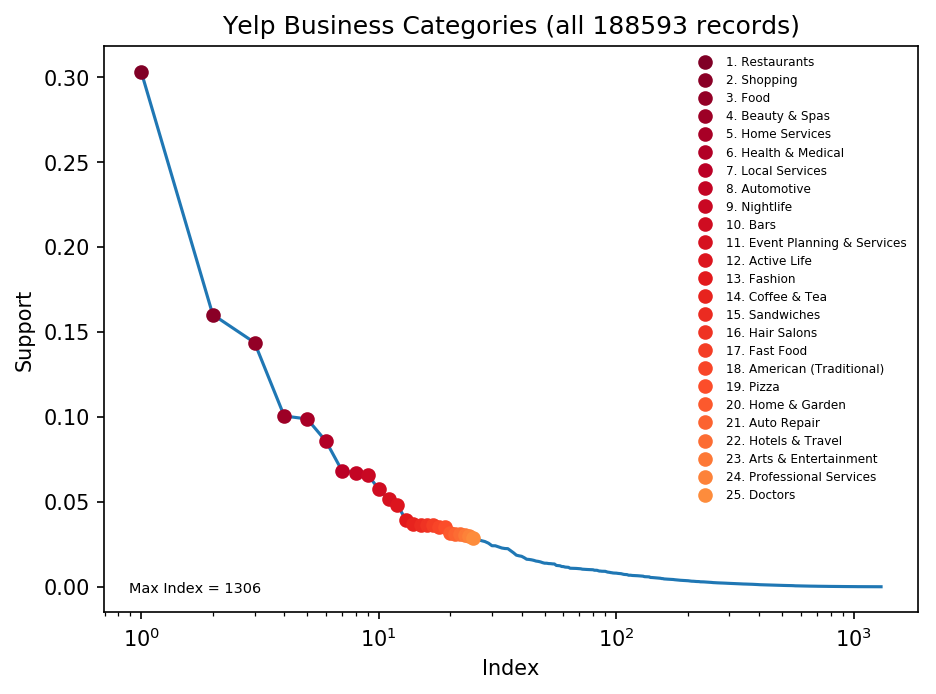

In [5]:
df_categories = pd.DataFrame.from_dict(categories, orient='index')
df_categories.columns = ['count']
df_categories['support'] = df_categories['count'] / nrecords
df_categories.sort_values(by='count', ascending=False, inplace=True)
print(df_categories.head())
print(df_categories.tail())
print(nrecords)
plot_support(df_categories, 'Yelp Business Categories (all {:d} records)'.format(nrecords))

                             count   support
BusinessAcceptsCreditCards  140391  0.744413
RestaurantsPriceRange2      107120  0.567996
BikeParking                  84891  0.450128
BusinessParking              68198  0.361615
GoodForKids                  64931  0.344292
RestaurantsTakeOut           61206  0.324540
OutdoorSeating               54181  0.287291
RestaurantsGoodForGroups     53839  0.285477
GoodForMeal                  53277  0.282497
WheelchairAccessible         52023  0.275848
RestaurantsDelivery          51668  0.273966
RestaurantsReservations      51363  0.272348
WiFi                         49026  0.259957
RestaurantsAttire            48182  0.255481
Alcohol                      47892  0.253944
HasTV                        47533  0.252040
ByAppointmentOnly            45423  0.240852
NoiseLevel                   43710  0.231769
RestaurantsTableService      43325  0.229728
Caters                       40038  0.212298
Ambience                     30123  0.159725
[NoAttribu

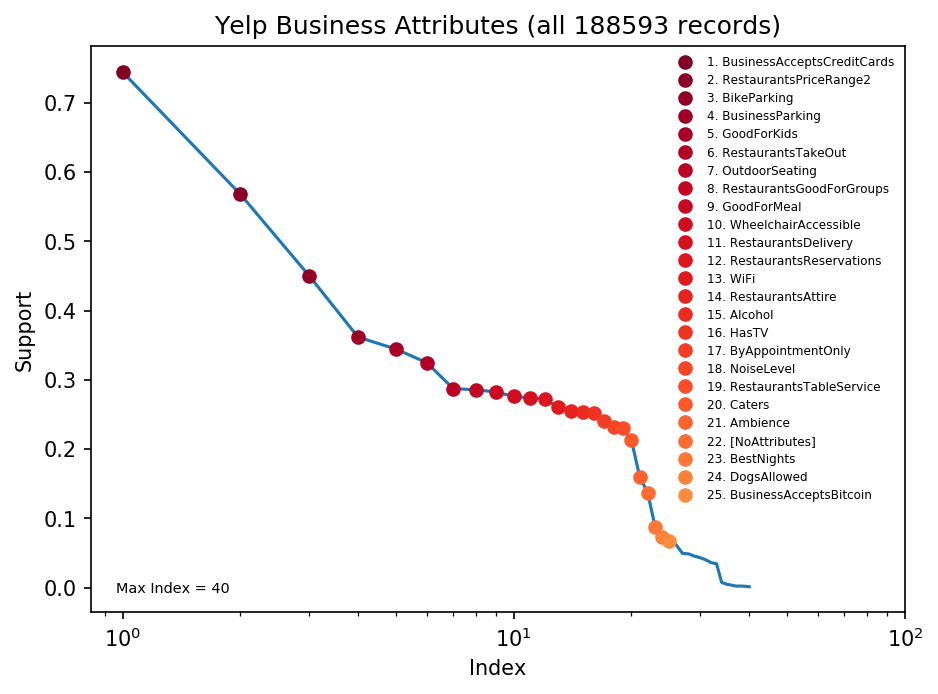

In [6]:
attributes_aggregated = dict()
for key, val in attributes.items():
    attributes_aggregated[key] = sum(val.values())
df_attributes = pd.DataFrame.from_dict(attributes_aggregated, orient='index')
df_attributes.columns = ['count']
df_attributes['support'] = df_attributes['count'] / nrecords
df_attributes.sort_values(by='count', ascending=False, inplace=True)
print(df_attributes.head(n=50))
print(df_attributes.tail())
print(nrecords)
plot_support(df_attributes, 'Yelp Business Attributes (all {:d} records)'.format(nrecords))

## Support of Attributes + Categories (Only Restaurants)

In [7]:
df_chunked = pd.read_json('/home/ryan/Yelp_Dataset/original_dataset/yelp_academic_dataset_business.json',
                  orient='records', lines='true', chunksize=1e4)

categories, attributes, nrecords = count_categories_attributes(df_chunked, only_restaurants=True)

print(nrecords)
pprint(categories)
pprint(attributes)

57173
Counter({'Restaurants': 57173,
         'Food': 11667,
         'Nightlife': 7948,
         'Bars': 7646,
         'Sandwiches': 6912,
         'Fast Food': 6812,
         'American (Traditional)': 6659,
         'Pizza': 6603,
         'Burgers': 5126,
         'Breakfast & Brunch': 5023,
         'Italian': 4550,
         'Mexican': 4419,
         'Chinese': 4247,
         'American (New)': 4230,
         'Coffee & Tea': 3108,
         'Cafes': 3056,
         'Japanese': 2566,
         'Chicken Wings': 2538,
         'Seafood': 2369,
         'Salad': 2350,
         'Event Planning & Services': 2247,
         'Sushi Bars': 2156,
         'Delis': 1835,
         'Canadian (New)': 1828,
         'Asian Fusion': 1780,
         'Mediterranean': 1744,
         'Barbeque': 1716,
         'Sports Bars': 1665,
         'Specialty Food': 1587,
         'Caterers': 1556,
         'Steakhouses': 1531,
         'Desserts': 1434,
         'Bakeries': 1419,
         'Indian': 1417,
         

                           count   support
Restaurants                57173  1.000000
Food                       11667  0.204065
Nightlife                   7948  0.139017
Bars                        7646  0.133734
Sandwiches                  6912  0.120896
Fast Food                   6812  0.119147
American (Traditional)      6659  0.116471
Pizza                       6603  0.115492
Burgers                     5126  0.089658
Breakfast & Brunch          5023  0.087856
Italian                     4550  0.079583
Mexican                     4419  0.077292
Chinese                     4247  0.074283
American (New)              4230  0.073986
Coffee & Tea                3108  0.054361
Cafes                       3056  0.053452
Japanese                    2566  0.044881
Chicken Wings               2538  0.044392
Seafood                     2369  0.041436
Salad                       2350  0.041103
Event Planning & Services   2247  0.039302
Sushi Bars                  2156  0.037710
Delis      

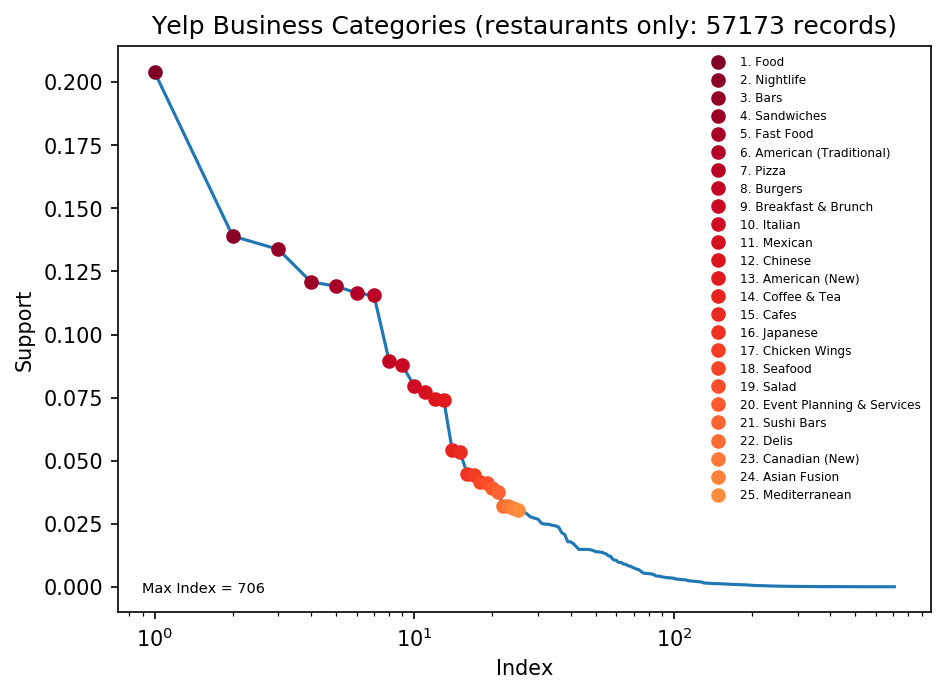

In [8]:
df_categories = pd.DataFrame.from_dict(categories, orient='index')
df_categories.columns = ['count']
df_categories['support'] = df_categories['count'] / nrecords
df_categories.sort_values(by='count', ascending=False, inplace=True)
print(df_categories.head(n=50))
print(df_categories.tail())
print(nrecords)
plot_support(df_categories.iloc[1:], 'Yelp Business Categories (restaurants only: {:d} records)'.format(nrecords))

                            count   support
GoodForMeal                 53199  0.930492
RestaurantsTakeOut          51142  0.894513
RestaurantsPriceRange2      51111  0.893971
RestaurantsGoodForGroups    50231  0.878579
GoodForKids                 49863  0.872142
RestaurantsReservations     49537  0.866440
RestaurantsDelivery         48900  0.855299
BusinessAcceptsCreditCards  48451  0.847445
RestaurantsAttire           48164  0.842426
OutdoorSeating              47552  0.831721
HasTV                       44343  0.775593
Alcohol                     43786  0.765851
RestaurantsTableService     43313  0.757578
NoiseLevel                  40896  0.715303
WiFi                        39861  0.697200
BikeParking                 38143  0.667151
Caters                      34180  0.597835
BusinessParking             32594  0.570094
Ambience                    28158  0.492505
WheelchairAccessible        23729  0.415039
                     count   support
Open24Hours            277  0.004845
Di

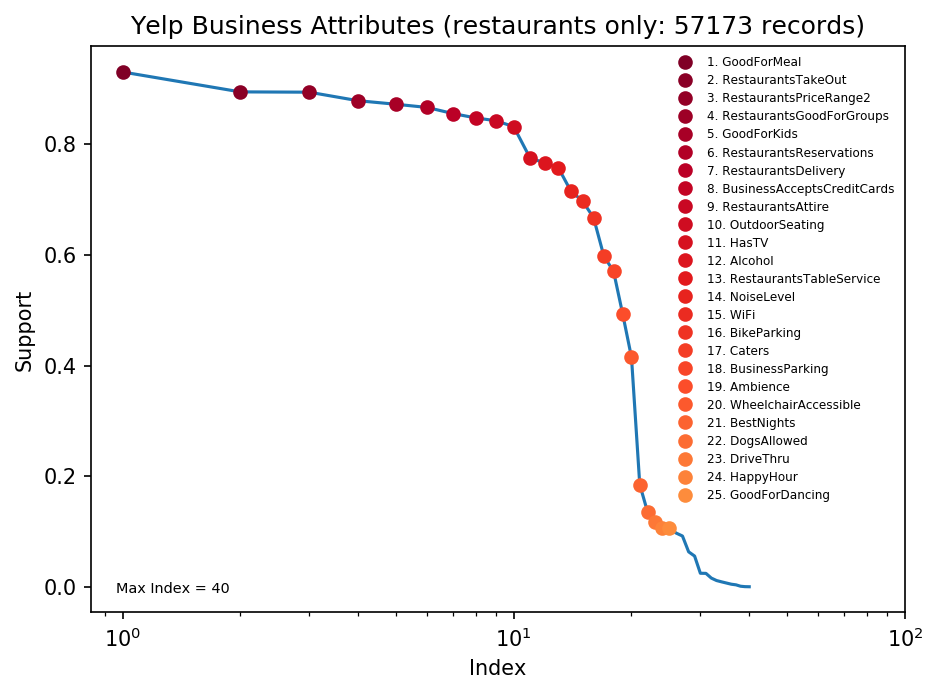

In [9]:
attributes_aggregated = dict()
for key, val in attributes.items():
    attributes_aggregated[key] = sum(val.values())
df_attributes = pd.DataFrame.from_dict(attributes_aggregated, orient='index')
df_attributes.columns = ['count']
df_attributes['support'] = df_attributes['count'] / nrecords
df_attributes.sort_values(by='count', ascending=False, inplace=True)
print(df_attributes.head(n=20))
print(df_attributes.tail())
print(nrecords)
plot_support(df_attributes, 'Yelp Business Attributes (restaurants only: {:d} records)'.format(nrecords))

## Detailed Breakdown of Attributes (Only Restaurants)

Select attributes according to $min\_supp = 0.2$.

In [10]:
high_support_attributes = df_attributes.loc[df_attributes['support'] > 0.2].index.values

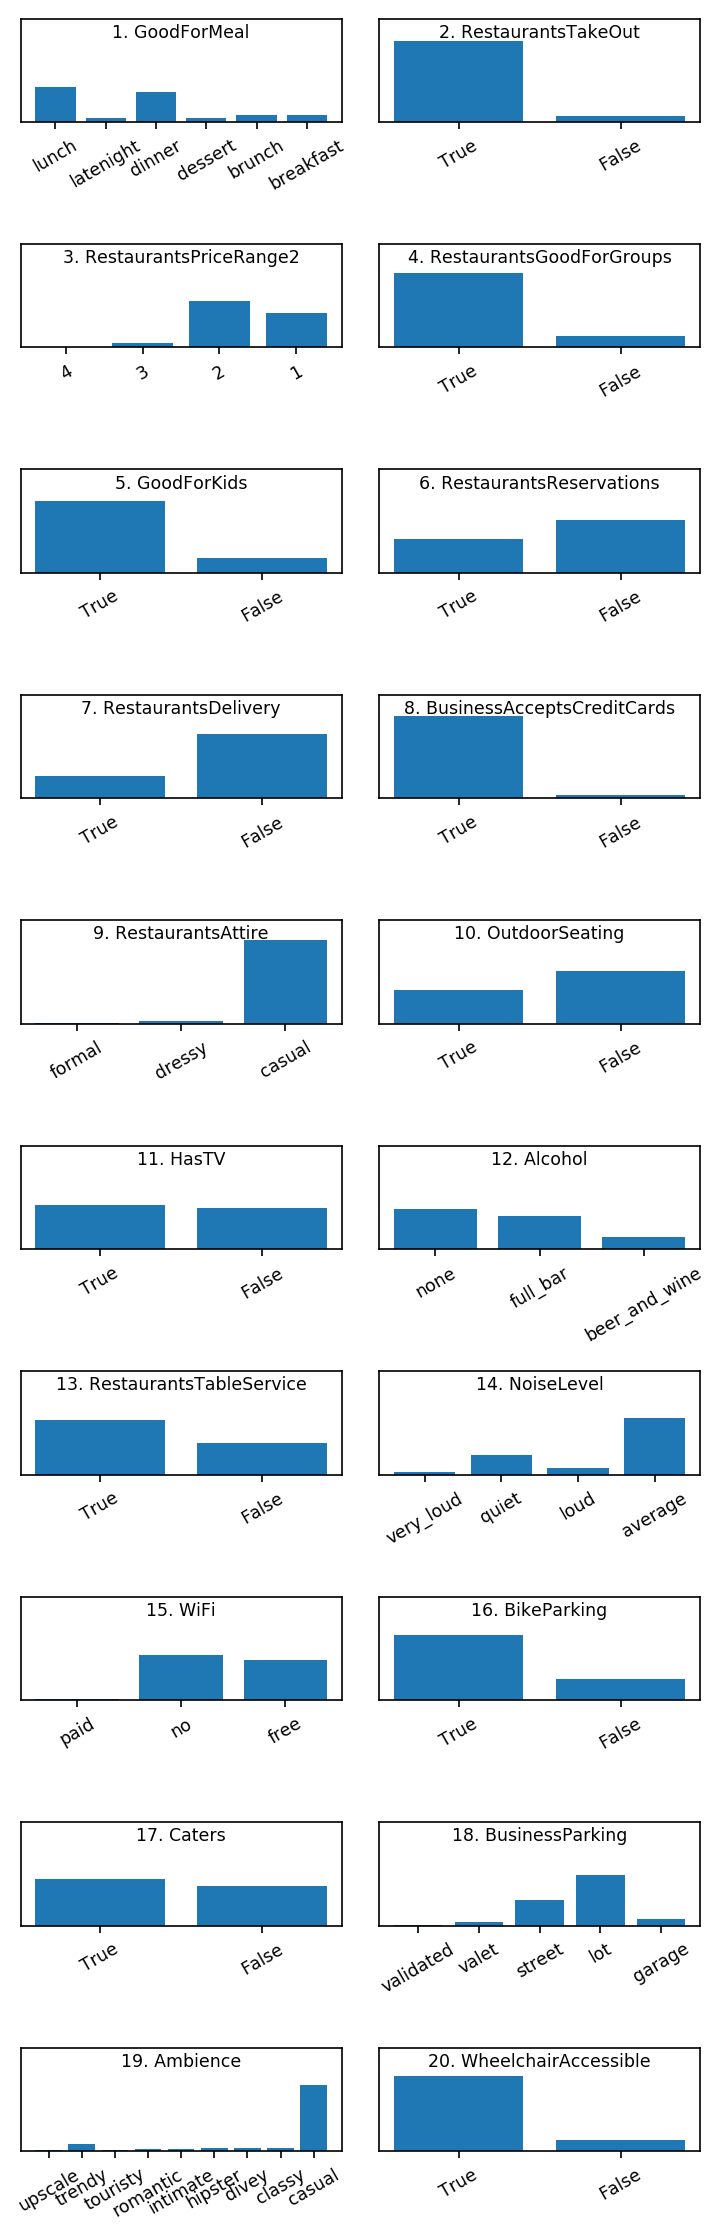

In [16]:
nc = 2
nr = int(np.ceil(len(high_support_attributes) / nc))
fig, ax = plt.subplots(nrows=nr, ncols=nc, sharey=True, figsize=[5,15], dpi=150)
ax = [item for sublist in ax for item in sublist]
iax = -1
for attribute in high_support_attributes:
    value = attributes[attribute]
    iax += 1
    plt.sca(ax[iax])
    labels = value.keys()
    labels = sorted(labels, reverse=True)
    counts = [value[l] for l in labels]
    proportions = np.array(list(counts)) / sum(counts)
    ind = np.arange(len(labels))
    plt.bar(ind, proportions)
    plt.xticks(ind, labels, rotation=30)
    plt.yticks([])
    plt.ylim([0, 1.2])
    plt.tick_params(labelsize='small')
    plt.text(0.5, 0.95, '{:d}. {:s}'.format(iax+1, attribute),
             ha='center', va='top', fontsize='small', transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()